# `makeNtuplesPAIReDjointMC` step by step

## The main function

In [1]:
# import all modules needed
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import sys
sys.path.insert(0, '..')
from tools.processEvents import processEvents
from tools.branchnames import BranchNames, outputTreeType
import json
import time
import argparse

In [2]:
# example inputs
inputFilePath = '../../data/example_PFNano_mcRun3_EE_allPF_noBTV.root'
outputFilePath = '../../test/output_mc_test.root'
batchsize = 10
N_update = 10
physics_process = 0


print("\n*****************************************************************")
print("  Start makeNtuplesPAIReDjointMC()")
print("*****************************************************************\n")

print("** Open input file:", inputFilePath)
inputTree = uproot.open(inputFilePath)['Events']

print("** Create output file:", outputFilePath)
outputFile = uproot.recreate(outputFilePath, compression=uproot.LZ4(4))

# create ROOT Tree in output file
outputTree = outputFile.mktree("tree", outputTreeType, 
                               title="PAIReD jets for training")

print('** Create tree "tree" entitled "PAIReD jets for training"',
        'in output file')

# number of events in input file
N_events = inputTree.num_entries
print("** Total number of events:", N_events)
print("** Batch size:", batchsize)

print("** Physics process:", physics_process)


*****************************************************************
  Start makeNtuplesPAIReDjointMC()
*****************************************************************

** Open input file: ../../data/example_PFNano_mcRun3_EE_allPF_noBTV.root
** Create output file: ../../test/output_mc_test.root
** Create tree "tree" entitled "PAIReD jets for training" in output file
** Total number of events: 568
** Batch size: 10
** Physics process: 0


In [3]:
# names of the branches that will be used from the input tree
with open('../tools/input_branches.json') as json_file:
                inputBranchNames = json.load(json_file)

In [4]:
# check output tree
outputTree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | uint64_t                 | AsDtype('>u8')
genweight            | float                    | AsDtype('>f4')
run                  | uint8_t                  | AsDtype('uint8')
Pileup_nPU           | uint8_t                  | AsDtype('uint8')
pv_n                 | uint8_t                  | AsDtype('uint8')
pv_ngood             | uint8_t                  | AsDtype('uint8')
fgrfccpu             | float                    | AsDtype('>f4')
fgrfcc               | float                    | AsDtype('>f4')
jet1_eta             | float                    | AsDtype('>f4')
jet1_phi             | float                    | AsDtype('>f4')
jet1_pt              | float                    | AsDtype('>f4')
jet1_nparticles      | float                    | AsDtype('>f4')
jet1_energy          | float                    | 

In [5]:
# limit the number of events for the demonstration here
N_events=10

t_start = time.time()
print("\n** Start processing data")

# number of processed batches
N_processed = 0

# iterate over all batches
for Events in inputTree.iterate(expressions=inputBranchNames,
        cut="nJet>=2", step_size=batchsize, entry_stop=N_events):
    
    # output update every N_update batches
    if N_processed % N_update == 0:
        print("process event batch", N_processed)

    # veto if there are no events with enough jets to create a
    # jet pair in the batch
    if len(Events) == 0:
        print("   !!! No events with more than one jet in batch !!!")
        print("   * Batch %i was not processed" % N_processed)
        N_processed += 1
        continue

    # process the events
    DataPAIReD = processEvents(Events, physics_process=physics_process)

    # check if processing worked
    if DataPAIReD == False:
        print("** Batch %i was not processed" % N_processed)
        N_processed += 1
        continue
    
    # fill in the tree
    outputTree.extend(DataPAIReD)

    N_processed += 1

t_end = time.time()
dt = t_end - t_start

print("\n** Written", outputTree.num_entries,
        "PAIReD jets to the output file in %.2f seconds" % dt)
print("** Computing time per PAIReD jet:",
        "%.3f seconds" % (dt / outputTree.num_entries))
print("** Computing time per event:",
        "%.3f seconds" % (dt / N_events))


** Start processing data
process event batch 0

** Written 19 PAIReD jets to the output file in 1.49 seconds
** Computing time per PAIReD jet: 0.078 seconds
** Computing time per event: 0.149 seconds


## A closer look at `processEvent()`

In [6]:
from tools.helpers import deltaPhi, deltaR, shiftPhi, Phi_mpi_pi, isoLeptonCut
from tools.getMCInfo import getMCInfo
from tools.PAIReD_geometries.ellipse import isInPAIReD

In [7]:
# load example event
i = 20
Events = inputTree.arrays(inputBranchNames, entry_start=0, entry_stop=i)

#### Cut all events without enough jets

In [8]:
# check if events have two or more jets that survive the selection cut
Jetcut = (((Events.Jet_pt * (1-Events.Jet_rawFactor)) > 20) & 
            (abs(Events.Jet_eta) < 2.5) & 
            (isoLeptonCut(Events)) &
            (Events.Jet_jetId > 4)
           )
Eventcut = (ak.sum(Jetcut, axis=1) > 1)

# cut all events that do not meet this criterion
Events = Events[Eventcut]

#### Get particle flow candidates

In [9]:
# sort the particles according to their pt
s = ak.argsort(Events.PFCands_pt, ascending=False, axis=1)
# and only include particles not considered pileup
s = s[Events.PFCands_puppiWeight[s] != 0]
Part = {"phi": Events.PFCands_phi[s], "eta": Events.PFCands_eta[s],
        "pt": Events.PFCands_pt[s], "charge": Events.PFCands_charge[s],
        "pid": Events.PFCands_pdgId[s], "d0val": Events.PFCands_d0[s],
        "d0err": Events.PFCands_d0Err[s], "dzval": Events.PFCands_dz[s],
        "dzerr": Events.PFCands_dzErr[s], "mass": Events.PFCands_mass[s],
        "puppiweight": Events.PFCands_puppiWeight[s]}

#### Get secondary vertices

In [10]:
# sort the secondary vertices (SV) according to their dlenSig
s = ak.argsort(Events.SV_dlenSig, ascending=False, axis=1)
SV = {k: Events["SV_"+k][s] for k in BranchNames["sv"][:16]}

#### Get jets

In [11]:
# define 4-vector for jets in order to calculate the energy
Jetcut = (((Events.Jet_pt * (1-Events.Jet_rawFactor)) > 20) & 
        (abs(Events.Jet_eta) < 2.5) & 
        (isoLeptonCut(Events)) &
        (Events.Jet_jetId > 4)
        )
Jet4 = vector.zip({"eta": Events.Jet_eta[Jetcut], "phi": Events.Jet_phi[Jetcut],
        "pt": Events.Jet_pt[Jetcut], "mass": Events.Jet_mass[Jetcut]})
# create jet object
Jet = ak.zip({"phi": Events.Jet_phi[Jetcut], "eta": Events.Jet_eta[Jetcut],
        "pt": Events.Jet_pt[Jetcut], "energy": Jet4.E,
        "nparticles": Events.Jet_nConstituents[Jetcut],
        "rawfactor": Events.Jet_rawFactor[Jetcut],
        "index": ak.local_index(Events.Jet_pt, axis=1)[Jetcut]})

#### Combine the jets to jet pairs
Those jet pairs will become the PAIReD jets in the end.

In [12]:
# get all jet pair combinations
Jet = ak.combinations(Jet, 2, axis=1, fields=["j1", "j2"],
        replacement=False)
# get also the combinations for the genJetIdx
Jet_genJetIdx = ak.combinations(Events.Jet_genJetIdx[Jetcut], 2, 
        axis=1, fields=["j1", "j2"], replacement=False)

#### Check which particles and secondary vertices lie in the ellipse

In [13]:
# get particles inside the PAIReD jet
isInPart = isInPAIReD(Jet.j1.eta, Jet.j2.eta, Jet.j1.phi, Jet.j2.phi,
            Part["eta"], Part["phi"])

# get the generated particles inside the PAIReD jet
isInGenPart = isInPAIReD(Jet.j1.eta, Jet.j2.eta, Jet.j1.phi, Jet.j2.phi,
            Events.GenPart_eta, Events.GenPart_phi)

# get the secondary vertices inside the PAIReD jet
isInSV = isInPAIReD(Jet.j1.eta, Jet.j2.eta, Jet.j1.phi, Jet.j2.phi,
            SV["eta"], SV["phi"])

#### Drop all particles and secondary vertices that are not in the ellipse

In [14]:
# make part arrays broadcastable with isInPart
# and drop all particles that are not in the PAIReD jet
for name in Part.keys():
    Part[name] = ak.unflatten(Part[name], 1, axis=0)
    Part[name], isInPart = ak.broadcast_arrays(Part[name], isInPart)
    Part[name] = Part[name][isInPart]

# make SV arrays broadcastable with isInSV
# and drop all SVs that are not in the PAIReD jet
for name in SV.keys():
    SV[name] = ak.unflatten(SV[name], 1, axis=0)
    SV[name], isInSV = ak.broadcast_arrays(SV[name], isInSV)
    SV[name] = SV[name][isInSV]

#### Calculate further quantities that are used

In [15]:
# calculate remaining variables (px,py,pz,E) from 4-vector
Part4 = vector.zip({"eta": Part["eta"], "phi": Part["phi"],
            "pt": Part["pt"], "mass": Part["mass"]})
Part["px"] = Part4.px
Part["py"] = Part4.py
Part["pz"] = Part4.pz
Part["energy"] = Part4.E

# calculate deta and dphi with respect to the jets
# (part_eta - jet1_eta) * (jet1_eta > 0 ? 1 : -1)
Part["deta1"] = (Part["eta"] - Jet.j1.eta) * (-1)**(Jet.j1.eta < 0)
# (part_eta - jet2_eta) * (jet2_eta > 0 ? 1 : -1)
Part["deta2"] = (Part["eta"] - Jet.j2.eta) * (-1)**(Jet.j2.eta < 0)
# dphi
Part["dphi1"] = deltaPhi(Part["phi"], Jet.j1.phi)
Part["dphi2"] = deltaPhi(Part["phi"], Jet.j2.phi)

# calculate the deta and dphi for the secondary vertices
SV["deta1"] = (SV["eta"] - Jet.j1.eta) * (-1)**(Jet.j1.eta < 0)
SV["deta2"] = (SV["eta"] - Jet.j2.eta) * (-1)**(Jet.j2.eta < 0)
SV["dphi1"] = deltaPhi(SV["phi"], Jet.j1.phi)
SV["dphi2"] = deltaPhi(SV["phi"], Jet.j2.phi)

# calculate dijets from dijet 4-vector
Dijet4 = vector.zip({"px": ak.sum(Part4.px, axis=2),
                "py": ak.sum(Part4.py, axis=2),
                "pz": ak.sum(Part4.pz, axis=2),
                "E":  ak.sum(Part4.E, axis=2)})

#### Prepare information for the output tree

In [16]:
# prepare jet and particle objects for the tree
part = ak.zip(Part)
sv = ak.zip(SV)
jet1 = Jet.j1
jet2 = Jet.j2
dijet = ak.zip({"eta": Dijet4.eta, "phi": Dijet4.phi,
                "pt": Dijet4.pt, "mass": Dijet4.mass,
                "nparticles": ak.num(part, axis=2),
                "index": ak.local_index(Jet.j1, axis=1)})

# prepare other single value branches
ones = ak.ones_like(Jet.j1.phi)
event = Events.event * ones
genweight = Events.genWeight * ones
run = Events.run * ones
Pileup_nPU = Events.Pileup_nPU * ones
pv_n = Events.PV_npvs * ones
pv_ngood = Events.PV_npvsGood * ones
fgrfcc = Events.Rho_fixedGridRhoFastjetCentralCalo * ones
fgrfccpu = Events.Rho_fixedGridRhoFastjetCentralChargedPileUp * ones

#### Get finally the MC information

In [17]:
# get summarized information from the MC simulation
MCInfo = getMCInfo(Events, isInGenPart, Jet_genJetIdx, Jetcut)

if MCInfo == False:
    #continue
    a = 0

#### Wrap everything inside a dictonary that will be return by the function

In [18]:
DataPAIReD = {
    "event" : event,
    "genweight": genweight,
    "run" : run,
    "Pileup_nPU" : Pileup_nPU,
    "pv_n" : pv_n,
    "pv_ngood" : pv_ngood,
    "fgrfcc" : fgrfcc,
    "fgrfccpu" : fgrfccpu,
    "jet1" : jet1,
    "jet2" : jet2,
    "dijet" : dijet,
    "part" : part,
    "sv" : sv
}

for name in MCInfo.keys():
    DataPAIReD[name] = MCInfo[name]

In [19]:
for name in DataPAIReD.keys():
    DataPAIReD[name] = ak.flatten(DataPAIReD[name], axis=1)
DataPAIReD

{'event': <Array [1.77e+06, 1.77e+06, ..., 1.77e+06, 1.77e+06] type='38 * float64'>,
 'genweight': <Array [0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909] type='38 * float32'>,
 'run': <Array [1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1] type='38 * float64'>,
 'Pileup_nPU': <Array [44, 44, 44, 45, 45, 45, ..., 28, 28, 28, 28, 28] type='38 * float64'>,
 'pv_n': <Array [35, 35, 35, 40, 40, 40, ..., 23, 23, 23, 23, 23] type='38 * float32'>,
 'pv_ngood': <Array [34, 34, 34, 40, 40, 40, ..., 21, 21, 21, 21, 21] type='38 * float32'>,
 'fgrfcc': <Array [17.3, 17.3, 17.3, 16.4, ..., 10.8, 10.8, 10.8] type='38 * float32'>,
 'fgrfccpu': <Array [23.9, 23.9, 23.9, 26.2, ..., 14.7, 14.7, 14.7] type='38 * float32'>,
 'jet1': <Array [{phi: 2.38, eta: 1.94, ...}, ...] type='38 * {phi: float32, eta: fl...'>,
 'jet2': <Array [{phi: -1.46, eta: 0.277, ...}, ...] type='38 * {phi: float32, eta: ...'>,
 'dijet': <Array [{eta: 2.24, phi: -2.66, ...}, ...] type='38 * {eta: float32, phi: f...'>,
 'part': <Ar

## A closer look at `getMCInfo()`

#### Check if the event is a Higgs event

In [20]:
# check if there is a Higgs in the event
isHiggs = ak.any(Events.GenPart_pdgId == 25, axis=1)

# define array of ones that matches the wanted ouput shape
ones = ak.ones_like(isInGenPart[:,:,0])

### In case it is a Higgs event

#### Get Higgs properties

In [21]:
# index of the Higgs boson
higgs_idx = ak.argmax(ak.local_index(Events.GenPart_pdgId, axis=1)*(Events.GenPart_pdgId == 25), axis=1, keepdims=True)

# Higgs properties
higgs_pt   = Events.GenPart_pt[higgs_idx][:,0]
higgs_eta  = Events.GenPart_eta[higgs_idx][:,0]
higgs_phi  = Events.GenPart_phi[higgs_idx][:,0]
higgs_mass = Events.GenPart_mass[higgs_idx][:,0]

#### Get the daughter particles

In [22]:
# indices of the daughter particles of the Higgs
d1 = ak.argmax(1*(Events.GenPart_genPartIdxMother == higgs_idx), axis=1, keepdims=True)
d2 = ak.argmax(ak.local_index(Events.GenPart_pdgId, axis=1)*(Events.GenPart_genPartIdxMother == higgs_idx), axis=1, keepdims=True)

# kinematics of the daughter particles
d1_eta = Events.GenPart_eta[d1]
d2_eta = Events.GenPart_eta[d2]
d1_phi = Events.GenPart_phi[d1]
d2_phi = Events.GenPart_phi[d2]
d1_pid = abs(Events.GenPart_pdgId[d1])
d2_pid = abs(Events.GenPart_pdgId[d2])

# ΔR_qq between the two daughter particles
drqq = deltaR(d1_eta, d2_eta, d1_phi, d2_phi)[:,0]

#### Based on the location of the daughter particles, label the PAIReD jet

In [23]:
# check if daughter particles are b or c
d1_is_b = ak.unflatten(d1_pid==5, 1, axis=0)
d2_is_b = ak.unflatten(d2_pid==5, 1, axis=0)
d1_is_c = ak.unflatten(d1_pid==4, 1, axis=0)
d2_is_c = ak.unflatten(d2_pid==4, 1, axis=0)

# check if daughter particles are in PAIReD jet
ones_ = ak.unflatten(ones, 1, axis=-1)
d1_isIn = isInGenPart[ones_*d1]
d2_isIn = isInGenPart[ones_*d2]

# count how many lie inside (0, 1 or 2?)
Ndaughters_isIn = (1*d1_isIn + d2_isIn)

# label the jet pairs:
# - BB if both daughters are b quarks and inside the PAIReD jet
# - CC if both daughters are c quarks and inside the PAIReD jet
# - LL else
label_BB = ( d1_is_b * d2_is_b * (Ndaughters_isIn == 2) )[:,:,0]
label_CC = ( d1_is_c * d2_is_c * (Ndaughters_isIn == 2) )[:,:,0]
label_LL = (~label_CC) & (~label_BB)

#### Save generated flavour of the Higgs

In [24]:
# generated higgs flavor:
# - digit represents the flavor of the daughter particle 
#   (e.g., 1 for d, 3 for s, or 5 for b)
higgs_flav = d1_pid[:,0]

### In case it is not a Higgs event

#### Set all MC values of (fake/proxy) Higgs

In [25]:
# get original partons and gluons from the collision
partons = (Events.LHEPart_status==1) & ((abs(Events.LHEPart_pdgId)<=5) | (abs(Events.LHEPart_pdgId)==21))

# check which events have less than two initial partons
less_than_two_partons = ak.sum(partons, axis=1) < 2

# get two partons of highest pT
s = ak.argsort(Events.LHEPart_pt[partons], axis=1, ascending=False)[:, :2]
partons4 = vector.zip({"phi" : Events.LHEPart_phi[partons][s],
                        "eta" : Events.LHEPart_eta[partons][s],
                        "pt"  : Events.LHEPart_pt[partons][s],
                        "mass": Events.LHEPart_mass[partons][s]})

# combine two highest pT partons to a "fake Higgs" / proxy Higgs
fakeHiggs4 = vector.zip({"px": ak.sum(partons4.px, axis=1),
                        "py": ak.sum(partons4.py, axis=1),
                        "pz": ak.sum(partons4.pz, axis=1),
                        "E":  ak.sum(partons4.E, axis=1)})

# set higgs_mass to -1 for events with less than two initial partons
higgs_pt = ak.nan_to_num(fakeHiggs4.pt)*(~less_than_two_partons) - 1*less_than_two_partons
higgs_eta = ak.nan_to_num(fakeHiggs4.eta)*(~less_than_two_partons)
higgs_phi = ak.nan_to_num(fakeHiggs4.phi)*(~less_than_two_partons)
higgs_mass = ak.nan_to_num(fakeHiggs4.mass)*(~less_than_two_partons) - 1*less_than_two_partons

# set drqq and higgs_flav to default=0
drqq = ones*0
higgs_flav = ones*0

# set signal labels to False and background label to True
label_LL = ones == 1
label_CC = ~label_LL
label_BB = ~label_LL

### Define labels for the background

In [26]:
# get c/b quarks in GenParts
# ensure that statusFlags bit 13 is True (isLastCopy)
# reject quarks without mother particle (mostly pile-up)
bit13 = (1 << 13)
charms = ((abs(Events.GenPart_pdgId) == 4) & 
          ((Events.GenPart_statusFlags & bit13) == bit13) &
          (Events.GenPart_genPartIdxMother != -1))
bottoms = ((abs(Events.GenPart_pdgId) == 5) & 
          ((Events.GenPart_statusFlags & bit13) == bit13) &
          (Events.GenPart_genPartIdxMother != -1))

# make charms and bottoms broadcastable and count number of b/c quarks in PAIReD jet
charms = ak.unflatten(charms, 1, axis=0)
charms, isInGenPart = ak.broadcast_arrays(charms, isInGenPart)
Ncharms = ak.sum(isInGenPart[charms], axis=2)

bottoms = ak.unflatten(bottoms, 1, axis=0)
bottoms, isInGenPart = ak.broadcast_arrays(bottoms, isInGenPart)
Nbottoms = ak.sum(isInGenPart[bottoms], axis=2)

# label the PAIReD jets according to the number of b/c quarks inside them:
#  - label bb: if two or more b quarks inside PAIReD jet
#  - label bl: if one b quark inside PAIReD jet
#  - label cc: if no b quarks but two or more c quarks
#  - label cl: if no b quarks but one or more c quarks
#  - label ll: if no b and no c quarks
label_bb = (label_LL) & (Nbottoms >= 2)
label_bl = (label_LL) & (Nbottoms == 1)
label_cc = (label_LL) & (Nbottoms == 0) & (Ncharms >= 2)
label_cl = (label_LL) & (Nbottoms == 0) & (Ncharms == 1)
label_ll = (label_LL) & (Nbottoms == 0) & (Ncharms == 0)

### Further MC information

#### Find vector bosons and their decay channel + Save generated flavour of the vector boson as well as the lepton channel (0L, 1L, 2L)

In [27]:
# check if there is a vector boson in the event
hasVector = ak.any((abs(Events.GenPart_pdgId) == 23) | (abs(Events.GenPart_pdgId) == 24), axis=1)

# index of the vector boson (W/Z)
vector_idx = ak.argmax(ak.local_index(Events.GenPart_pdgId, axis=1)*((abs(Events.GenPart_pdgId) == 23) | (abs(Events.GenPart_pdgId) == 24)), axis=1, keepdims=True)

# indices of the daughter particles of the vector boson
vector_d1 = ak.argmax(1*(Events.GenPart_genPartIdxMother == vector_idx), axis=1, keepdims=True)
vector_d2 = ak.argmax(ak.local_index(Events.GenPart_pdgId, axis=1)*(Events.GenPart_genPartIdxMother == vector_idx), axis=1, keepdims=True)

# PID of the daughters of the vector boson
vector_d1_pid = abs(Events.GenPart_pdgId[vector_d1])[:,0]
vector_d2_pid = abs(Events.GenPart_pdgId[vector_d2])[:,0]

# generated vector flavor:
# - digit represents the flavor of the daughter particles
#   (11 for e-like,  13 for mu-like, 15 for tau-like)
# - if there is no vector boson, = 0
vector_flav = (11 * ((vector_d1_pid==11) | (vector_d1_pid==12)) +
               13 * ((vector_d1_pid==13) | (vector_d1_pid==14)) +
               15 * ((vector_d1_pid==15) | (vector_d1_pid==16))) * hasVector

# lepton channel:
# - number of charged leptons the vector boson decays into (0L, 1L, 2L)
# - if there is no vector boson, = -1
lepton_channel = (1* ((vector_d1_pid==11) | (vector_d1_pid==13) | (vector_d1_pid==15)) + 
                  1* ((vector_d2_pid==11) | (vector_d2_pid==13) | (vector_d2_pid==15))) * hasVector - 1*(~hasVector)

#### The di-GenJet and its mass (essentially a fake background Higgs)

In [28]:
# add the four-vectors of the two generated jets of the ellipse 
# (matched to the two underlying AK4 jets)
# and save the combined invariant mass and kinematics
# 4-vector of the two generated jets
GenJet1 = vector.zip({
    "eta":  Events.GenJet_eta[Jet_genJetIdx.j1], 
    "phi":  Events.GenJet_phi[Jet_genJetIdx.j1],
    "pt":   Events.GenJet_pt[Jet_genJetIdx.j1], 
    "mass": Events.GenJet_mass[Jet_genJetIdx.j1]
})
GenJet2 = vector.zip({
    "eta":  Events.GenJet_eta[Jet_genJetIdx.j2], 
    "phi":  Events.GenJet_phi[Jet_genJetIdx.j2],
    "pt":   Events.GenJet_pt[Jet_genJetIdx.j2], 
    "mass": Events.GenJet_mass[Jet_genJetIdx.j2]
})

# combined 4-vector
GenDijet4 = GenJet1 + GenJet2

# check if jets have matched GenJet
genjet1_matched = (Jet_genJetIdx.j1 != -1)
genjet2_matched = (Jet_genJetIdx.j2 != -1)

# save kinematics and set them to zero for PAIReD jets
# in which at least one Jet is not matched to a GenJet
bothJetHaveGenJet = genjet1_matched * genjet2_matched
gendijet_eta  = GenDijet4.eta  * bothJetHaveGenJet
gendijet_phi  = GenDijet4.phi  * bothJetHaveGenJet
gendijet_pt   = GenDijet4.pt   * bothJetHaveGenJet
gendijet_mass = GenDijet4.mass * bothJetHaveGenJet

# get parton flavour of matched GenJet
genjet1_flav = Events.GenJet_partonFlavour[Jet_genJetIdx.j1] * genjet1_matched
genjet2_flav = Events.GenJet_partonFlavour[Jet_genJetIdx.j2] * genjet2_matched

#### Number of c jets in event

In [29]:
n_c = ak.sum(abs(Events.Jet_partonFlavour[Jetcut])==4, axis=1)  # take selection cut into account

#### Wrap everything inside a dictonary that will be returned by the function

In [30]:
# vectorize the scalars for the number jet pairs
# and define dictionary with all the outputs
MCInfo = {
    "MC_higgs_pt" : higgs_pt * ones,
    "MC_higgs_eta" : higgs_eta * ones,
    "MC_higgs_phi" : higgs_phi * ones,
    "MC_higgs_mass" : higgs_mass * ones,
    "MC_higgs_flav" : higgs_flav * ones,
    "MC_vector_flav" : vector_flav * ones,
    "MC_lepton_channel" : lepton_channel * ones,
    "MC_gendijet_pt" : gendijet_pt,
    "MC_gendijet_eta" : gendijet_eta,
    "MC_gendijet_phi" : gendijet_phi,
    "MC_gendijet_mass" : gendijet_mass,
    "MC_genjet1_flav" : genjet1_flav,
    "MC_genjet2_flav" : genjet2_flav,
    "MC_genjet1_matched" : genjet1_matched,
    "MC_genjet2_matched" : genjet2_matched,
    "MC_drqq" : drqq * ones,
    "MC_n_c" : n_c * ones,
    "label_BB" : label_BB,
    "label_CC" : label_CC,
    "label_LL" : label_LL,
    "label_bb" : label_bb,
    "label_bl" : label_bl,
    "label_cc" : label_cc,
    "label_cl" : label_cl,
    "label_ll" : label_ll
}

In [31]:
MCInfo

{'MC_higgs_pt': <Array [[33.6, 33.6, 33.6], ..., [394, ..., 394]] type='10 * var * float64'>,
 'MC_higgs_eta': <Array [[-0.755, -0.755, -0.755], ..., [-2.05, ...]] type='10 * var * float32'>,
 'MC_higgs_phi': <Array [[-2.09, -2.09, -2.09], ..., [-1.98, ...]] type='10 * var * float32'>,
 'MC_higgs_mass': <Array [[14.7, 14.7, 14.7], ..., [1.02e+03, ...]] type='10 * var * float64'>,
 'MC_higgs_flav': <Array [[0, 0, 0], ..., [0, 0, 0, 0, ..., 0, 0, 0, 0]] type='10 * var * int64'>,
 'MC_vector_flav': <Array [[11, 11, 11], ..., [13, 13, ..., 13]] type='10 * option[var * int64]'>,
 'MC_lepton_channel': <Array [[2, 2, 2], ..., [2, 2, 2, ..., 2, 2]] type='10 * option[var * int64]'>,
 'MC_gendijet_pt': <Array [[65.8, 72.6, 40.6], ..., [245, ..., 29.2]] type='10 * var * float32'>,
 'MC_gendijet_eta': <Array [[2.18, 2.02, -0.108], ..., [-2.93, ...]] type='10 * var * float32'>,
 'MC_gendijet_phi': <Array [[2.59, 2.54, -1.57], ..., [-2.33, ..., 3.07]] type='10 * var * float32'>,
 'MC_gendijet_mass':

## A closer look at `isInPAIReD()`
Take PAIReDEllipse as an example.

#### Get arguments for the function

In [32]:
# load example event
i = 6
Events = inputTree.arrays(inputBranchNames, entry_start=0, entry_stop=i)

# sort the particles according to their pt
s = ak.argsort(Events.PFCands_pt, ascending=False)
# and only include particles not considered pileup
s = s[Events.PFCands_puppiWeight[s] != 0]
phi_p = Events.PFCands_phi[s]
eta_p = Events.PFCands_eta[s]

# define 4-vector for jets in order to calculate the energy
Jetcut = (((Events.Jet_pt * (1-Events.Jet_rawFactor)) > 20) & 
        (abs(Events.Jet_eta) < 2.5) & 
        (isoLeptonCut(Events)) &
        (Events.Jet_jetId > 4)
       )
Jet4 = vector.zip({"eta": Events.Jet_eta[Jetcut], "phi": Events.Jet_phi[Jetcut],
        "pt": Events.Jet_pt[Jetcut], "mass": Events.Jet_mass[Jetcut]})
# create jet object
Jet = ak.zip({"phi": Events.Jet_phi[Jetcut], "eta": Events.Jet_eta[Jetcut],
        "pt": Events.Jet_pt[Jetcut], "energy": Jet4.E,
        "nparticles": Events.Jet_nConstituents[Jetcut],
        "index": ak.local_index(Events.Jet_pt, axis=1)[Jetcut]})
# get all jet pair combinations
Jet = ak.combinations(Jet, 2, axis=1, fields=["j1", "j2"],
        replacement=False)

eta_j1 = Jet.j1.eta
eta_j2 = Jet.j2.eta
phi_j1 = Jet.j1.phi
phi_j2 = Jet.j2.phi

semimajoradd = 1.

#### Add dimension

In [33]:
# in order to be able to broadcast the arrays with the particle arrays to
# the format
# (N_events, N_jetpairs, N_particles),
# we have to add one dimension to the jet related data. So, we have to add a
# one:
# (N_events, N_jetpairs) -> (N_events, N_jetpairs, 1)
eta_j1 = ak.unflatten(eta_j1, 1, axis=-1)
eta_j2 = ak.unflatten(eta_j2, 1, axis=-1)
phi_j1 = ak.unflatten(phi_j1, 1, axis=-1)
phi_j2 = ak.unflatten(phi_j2, 1, axis=-1)
# and add one to the particle related data:
# (N_events, N_particles) -> (N_events, 1, N_particles)
eta_p = ak.unflatten(eta_p, 1, axis=0)
phi_p = ak.unflatten(phi_p, 1, axis=0)

#### Determine focal points of the ellipse

In [34]:
# distance in between the jets 1 and 2
d_12 = deltaR(eta_j1, eta_j2, phi_j1, phi_j2)

# semiminor and semimajor axis of the enveloping ellipse
semiminor = 1.5
semimajor = np.maximum(semiminor, d_12/2 + semimajoradd)

# distance of focus points to center
focus = np.sqrt(semimajor**2 - semiminor**2)

# center point
eta_c = (eta_j1 + eta_j2) / 2
phi_c = Phi_mpi_pi(phi_j1 + Phi_mpi_pi(phi_j2-phi_j1) / 2)

# focus 1
eta_f1 = eta_c + focus / (d_12/2) * (eta_j1-eta_c)
phi_f1 = Phi_mpi_pi(phi_c + focus/(d_12/2) * deltaPhi(phi_j1, phi_c))

# focus 2
eta_f2 = eta_c + focus / (d_12/2) * (eta_j2-eta_c)
phi_f2 = Phi_mpi_pi(phi_c + focus/(d_12/2) * deltaPhi(phi_j2, phi_c))

#### Shift particles in phi direction

In [35]:
# in order to treat the jump in the phi space from phi=pi to phi=-pi
# correctly, the phi values of the particles might have to be shifted:
#if phi_c >= 0:
#    shift = 2*np.pi
#    lim = phi_c - np.pi
#else:
#    shift = -2*np.pi
#    lim = phi_c + np.pi

# define shift and lim according to the upper if statement
shift = 2*np.pi * (phi_c>=0) - 2*np.pi * (phi_c<0)
lim = phi_c - np.pi * (phi_c>=0) + np.pi * (phi_c<0)

# eventually shift phi_p
phi_p = shiftPhi(phi_p, shift, lim)

#### Calculate the distances between particles and focal points

In [36]:
# Distances to the focus points
d_f1 = np.hypot(eta_p-eta_f1, phi_p-shiftPhi(phi_f1, shift, lim))
d_f2 = np.hypot(eta_p-eta_f2, phi_p-shiftPhi(phi_f2, shift, lim))
d_sum = d_f1 + d_f2

#### Return the result

In [37]:
# if particle is in the ellipse,
# the sum of the distances will be less than 2*semimajor
inEllipse = d_sum < 2*semimajor
inEllipse

<Array [[], [], ..., [[False, False, ..., False]]] type='6 * var * var * bool'>

# Check the time performance (computation time)

In [52]:
def run_test(batchsize = 1, N_events = 100, N_update = 100):
    
    t = []
    
    # number of processed batches
    N_processed = 0
    
    t1 = time.time()
    # iterate over all batches
    for Events in inputTree.iterate(expressions=inputBranchNames,
            cut="nJet>=2", step_size=batchsize, entry_stop=N_events):
        
        t2 = time.time()
        t.append(t2-t1)
        t1 = time.time()
        
        # output update every N_update batches
        if N_processed % N_update == 0:
            print("process event batch", N_processed)
    
        # number of events in batch
        N_events_in_batch = len(Events)
        
        # veto if there are no events with enough jets to create a
        # jet pair in the batch
        if N_events_in_batch == 0:
            print("   !!! No events with more than one jet in batch !!!")
            print("   * Batch %i was not processed" % N_processed)
            N_processed += 1
            t2 = time.time()
            t.append(t2-t1)
            t.append(0)
            t.append(0)
            t.append(0)
            t1 = time.time()
            continue
    
        t2 = time.time()
        t.append(t2-t1)
        t1 = time.time()
    
        # process the events
        DataPAIReD = processEvents(Events)
        
        t2 = time.time()
        t.append(t2-t1)
        t1 = time.time()
            
        # check if processing worked
        if DataPAIReD == False:
            print("   * Batch %i was not processed" % N_processed)
            N_processed += 1
            t2 = time.time()
            t.append(t2-t1)
            t.append(0)
            t1 = time.time()
            continue

        t2 = time.time()
        t.append(t2-t1)
        t1 = time.time()
        
        # fill in the tree
        outputTree.extend(DataPAIReD)
    
        t2 = time.time()
        t.append(t2-t1)
        
        N_processed += 1
        t1 = time.time()

    return np.array([sum(t[k::5]) for k in range(5)]) / N_events

In [53]:
parts = ["load Events", "N_events=0 veto", "processEvents()", "check processing", "write to outputTree"]
batchsizes = [1, 100, 1000]

times = []

for num in batchsizes:
    times.append(run_test(num, 1000))

process event batch 0
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 2 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 3 was not processed
   !!! No events with more than one jet in batch !!!
   * Batch 5 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 9 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 10 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 12 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 14 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batch 15 was not processed
   !!! No event in the batch had more than one jet surviving the selection cut !!!
   * Batc

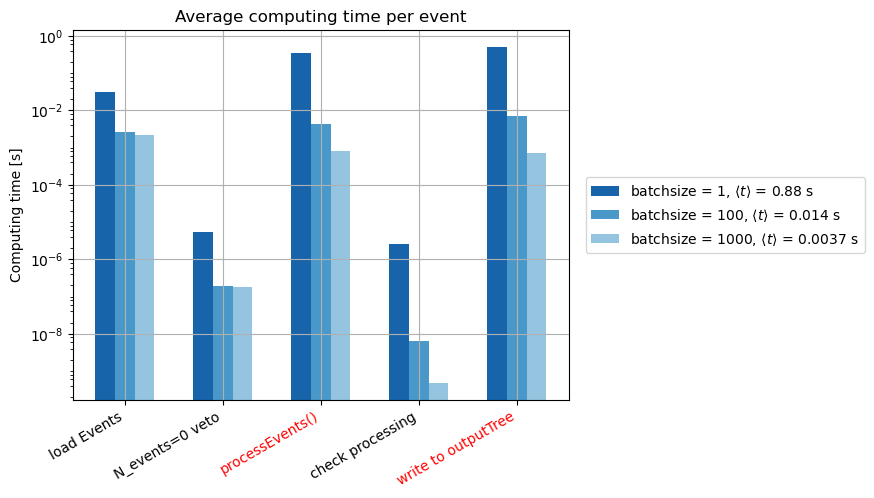

In [65]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, NullFormatter
import seaborn
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=seaborn.color_palette("Blues_r", 4))

x = np.arange(len(parts))
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.bar(x-0.2, times[0], 0.2, label=r"batchsize = %i, $\langle t \rangle$ = %.2f s" % (batchsizes[0], np.sum(times[0])))
plt.bar(x, times[1], 0.2, label=r"batchsize = %i, $\langle t \rangle$ = %.3f s" % (batchsizes[1], np.sum(times[1])))
plt.bar(x+0.2, times[2], 0.2, label=r"batchsize = %i, $\langle t \rangle$ = %.4f s" % (batchsizes[2], np.sum(times[2])))
plt.ylabel("Computing time [s]")
plt.xticks(x, parts)
plt.legend(bbox_to_anchor = (1.02, 0.5), loc='center left')
plt.title("Average computing time per event")
plt.xticks(rotation=30, ha='right')
plt.yscale("log")
locmin = LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8, 1),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())
plt.gca().get_xticklabels()[2].set_color("red")
plt.gca().get_xticklabels()[4].set_color("red")
plt.grid()
plt.savefig("plots/time_performance_batchsize.png", dpi=300, bbox_inches="tight")
plt.show()